<a href="https://colab.research.google.com/github/lucas-prado/data_science_portfolio/blob/main/%5BPROJETO%5D_Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://images.unsplash.com/photo-1592772874383-d08932d29db7?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=699&q=80" width="60%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acarretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor ou igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [ ]:
# importar os pacotes necessários

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [ ]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe

df = pd.read_csv(file_path)

# criando a base teste

#Parâmetros da df.sample:

#=> frac: porcentagem de linhas do dataframe que será utilizado na base teste criada.
#=> random_state=0: tira a aleatoriedade de formação da base,a cada rodada de leitura de código. Ele permanecerá com os dados mantidos para que o resultado não mude a cada reprocessamento.

test = df.sample(frac=0.15, random_state=0)

#eliminando as variáveis da base teste na base treino/validação:

df.drop(test.index, inplace=True)

print(f'dimensões da base treino/validação => linhas:{df.shape[0]}/colunas:{df.shape[1]}')
print(f'dimensões da base teste => linhas:{test.shape[0]}/colunas:{test.shape[1]}')

dimensões da base treino/validação => linhas:242086/colunas:31
dimensões da base teste => linhas:42721/colunas:31


Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

#### **Análise Exploratória**

**Variáveis Target:**

  * Fraude (`Class == 1`)
  * Normal (`Class == 0`)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


A princípio, todos as variáveis **Vs** já foram padronizadas de acordo com o processo de normalização. Visto que apresentam dimensões bastante similares:

* média próxima zero.
* variância próxima de 1.
* Valores de média e mediana próximos indicando a baixa existência de outliers.

O mesmo não pode se concluir das variáveis **Time** e **Amount** que necessitarão passar pelas transformações mais a frente.

In [ ]:
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00
mean,94857.60,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,88.61,0.00
std,47490.66,1.96,1.65,1.51,1.42,1.37,1.33,1.22,1.20,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.76,0.73,0.73,0.63,0.61,0.52,0.48,0.40,0.33,247.66,0.04
min,0.00,-56.41,-72.72,-33.68,-5.68,-42.15,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-25.22,-34.83,-10.93,-44.81,-2.82,-10.30,-2.60,-22.57,-11.71,0.00,0.00
25%,54234.00,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.65,-0.53,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.66,0.00
50%,84747.00,0.02,0.06,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139362.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.46,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.58,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,23.92,44.05,20.01,15.59,23.75,12.02,7.85,4.57,10.53,5.83,7.06,9.21,5.04,5.57,39.42,27.20,10.50,22.53,4.02,7.52,3.52,12.15,33.85,19656.53,1.00


Sem presença de **missing values** para possível tratamento.

In [ ]:
df.isnull().sum()/df.shape[0]

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

O gráfico abaixo nos mostra que os dados de fraudes estão **consideravelmente desbalanceados.**

Os dados apresentam uma quantidade muito abaixo de confirmação de fraudes em relação aos processos normais.

Necessitaremos tratar deste desbalanceamento via a técnica de **undersampling.**

0    241668
1       418
Name: Class, dtype: int64

 Registros de 0.17% de fraudes 



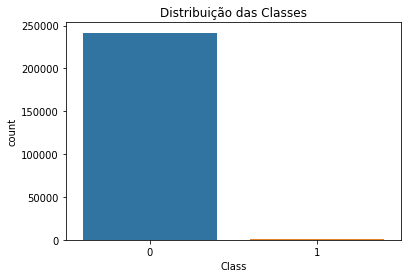

In [ ]:
print(df.Class.value_counts())
print(f"\n Registros de {df[df.Class==1].shape[0]/df.shape[0]:.2%} de fraudes \n")

fig, ax = plt.subplots()

sns.countplot(x="Class", data=df, ax=ax)
ax.set_title("Distribuição das Classes")

plt.show();

## **Análise das distribuições das variáveis**

Optamos por analisar a distribuição das variáveis, via histograma, a fim de entender se a relação de **TIME_X_CLASS** e **AMOUNT_X_CLASS** se comporta de maneira diferente quando as operações são fraudadas ou não.

#### **TIME X CLASS:**

* Se tratando da relação TIME X CLASS, não é possível perceber que exista diferença na variável TIME em relação à frequência absoluta das operações fraudadas e operações normais. O intervalo da variável TIME entre ambas as classes de operações se encontra entre 0 e 175000.

#### **AMOUNT X CLASS:**

* Se tratando da relação AMOUNT X CLASS, é possível perceber a existência de uma cauda com mais frequências absolutas na distribuição de operações fraudadas do que em operações normais. Logo, pode-se tirar a conclusão de que operações muito distantes da média podem indicar a existência de fraudes.

* O boxplot criado também evidência a conclusão chegada acima.

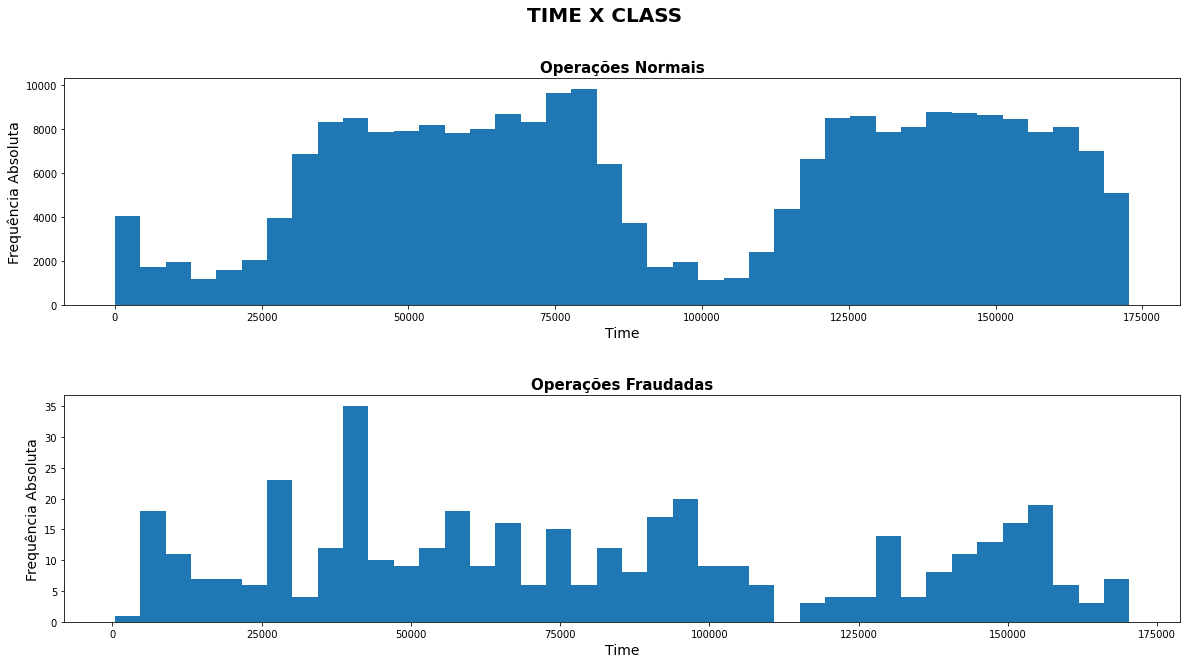

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

plt.suptitle("TIME X CLASS", size=20, weight="bold")
plt.subplots_adjust(hspace=0.4)

ax[0].hist(df.Time.loc[df.Class==0], bins=40)
ax[0].set_title("Operações Normais", fontdict={"size":15, "weight":"bold"})
ax[0].set_ylabel("Frequência Absoluta", size=14)
ax[0].set_xlabel("Time", size=14)

ax[1].hist(df.Time.loc[df.Class==1], bins=40)
ax[1].set_title("Operações Fraudadas", fontdict={"size":15, "weight":"bold"})
ax[1].set_ylabel("Frequência Absoluta", size=14)
ax[1].set_xlabel("Time", size=14)

plt.show();

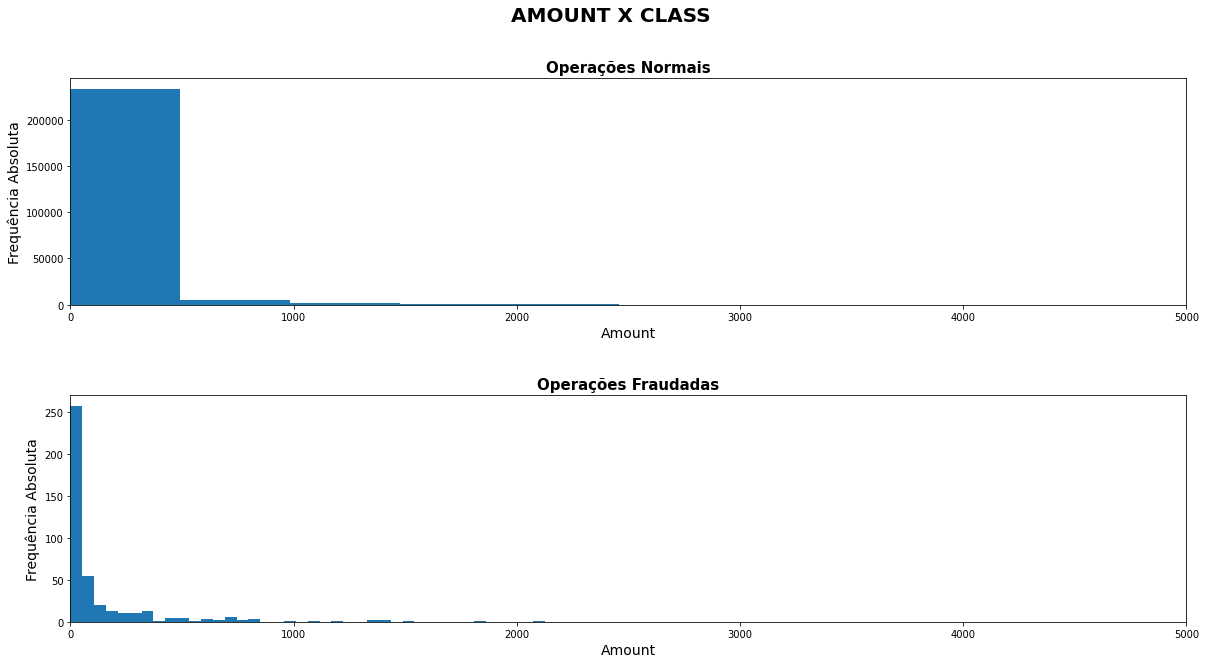

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

plt.suptitle("AMOUNT X CLASS", size=20, weight="bold")
plt.subplots_adjust(hspace=0.4)

ax[0].hist(df.Amount.loc[df.Class==0], bins=40)
ax[0].set_title("Operações Normais", fontdict={"size":15, "weight":"bold"})
ax[0].set_xlim(0, 5000)
ax[0].set_ylabel("Frequência Absoluta", size=14)
ax[0].set_xlabel("Amount", size=14)

ax[1].hist(df.Amount.loc[df.Class==1], bins=40)
ax[1].set_title("Operações Fraudadas", fontdict={"size":15, "weight":"bold"})
ax[1].set_xlim(0, 5000)
ax[1].set_ylabel("Frequência Absoluta", size=14)
ax[1].set_xlabel("Amount", size=14)

plt.show();

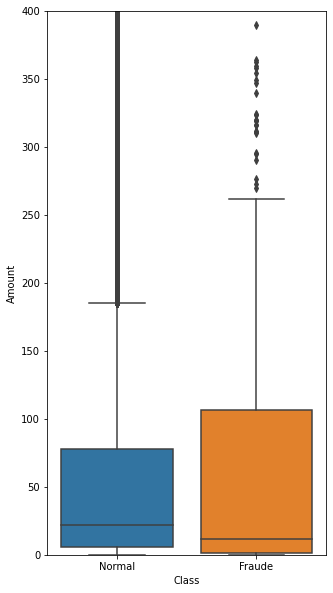

In [ ]:
fig, ax = plt.subplots(figsize=(5,10))

sns.boxplot(x="Class", y="Amount", data=df, ax=ax)
ax.set_ylim(0, 400)
ax.set_xticklabels(["Normal", "Fraude"])

plt.show();

## **Preparação dos Dados**

Neste tópico, iremos tratar a nossa base de dados a fim de iniciar o processo de modelagem via **Regressão Logística**. Este processo considera os seguintes tratamentos:

* Normalizar os dados que ainda não haviam sido pré-processados (`Time` e `Amount`)
* Dividir o conjunto de dados entre treino e validação
* Balancear o conjunto de dados via técnica de **undersampling**

In [ ]:
df_standard = df.copy()

#PADRONIZAÇÃO DOS DADOS.

#Time e Amount possuem muitos outliers então iremos padronizá-los.

 #Guarda informações de média e variância.
scaler = StandardScaler()

#Aplica-se a fórmula do z score((x - média)/std)
df_standard["std_Amount"] = scaler.fit_transform(df_standard["Amount"].values.reshape(-1,1))
df_standard["std_Time"] = scaler.fit_transform(df_standard["Time"].values.reshape(-1,1))

df_standard.drop(columns=["Amount", "Time"], inplace=True)

df_standard.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_Amount,std_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.246341,-1.997399
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.346945,-1.997399
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.171178,-1.997378
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140872,-1.997378
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075195,-1.997357


In [ ]:
df_standard .describe().round(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_Amount,std_Time
count,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00,242086.00
mean,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
std,1.96,1.65,1.51,1.42,1.37,1.33,1.22,1.20,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.76,0.73,0.73,0.63,0.61,0.52,0.48,0.40,0.33,0.04,1.00,1.00
min,-56.41,-72.72,-33.68,-5.68,-42.15,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-25.22,-34.83,-10.93,-44.81,-2.82,-10.30,-2.60,-22.57,-11.71,0.00,-0.36,-2.00
25%,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.65,-0.53,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,0.00,-0.33,-0.86
50%,0.02,0.06,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,0.00,-0.27,-0.21
75%,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.46,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,0.00,-0.04,0.94
max,2.45,22.06,9.38,16.88,34.80,23.92,44.05,20.01,15.59,23.75,12.02,7.85,4.57,10.53,5.83,7.06,9.21,5.04,5.57,39.42,27.20,10.50,22.53,4.02,7.52,3.52,12.15,33.85,1.00,79.01,1.64


In [ ]:
#Criando os dataframes de features e target.

X = df_standard.drop(columns="Class")
y = df_standard.Class

#Separando os dataframes entre train e test.

#O que é o stratify?

#Manterá os datasets de treino e teste com as classificações igualmente proporcionais em relação à y. 
#Visto que temos poucos casos de fraudes, conseguimos assim manter uma quantidade proporcionalmente igual em ambos os datasets.

#shuffle=True: aleatorizamos os datasets.

#random_state = 42: mantém os resultados do modelo, não aleatorizando os resultados a cada processamento do código.

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.15, stratify=y, random_state=42,)

In [ ]:
#resultado do stratify para a base treino.

sum(y_train)/len(y_train)

0.0017252020430279969

In [ ]:
#resultado do stratify para a base de validação.

sum(y_val)/len(y_val)

0.0017349158703494616

0    355
1    355
Name: Class, dtype: int64


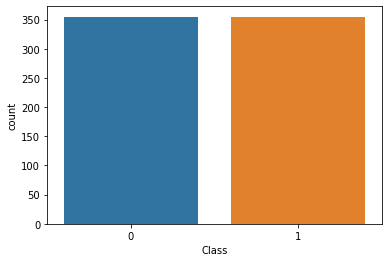

In [ ]:
# usar técnica under-sampling

#A técnica undersampling elimina aleatoriamente exemplos na classe majoritária.
#A técnica oversampling duplica aleatoriamente exemplos na classe majoritária.

res = RandomUnderSampler()
X_res, y_res = res.fit_resample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())

# plotar a nova distribuição de classes
sns.countplot(x=y_res);

plt.show();

## **Desenvolvimento do Modelo de Regressão Logística**

O modelo de regressão logística é baseado na previsão de classificações binárias (0 e 1), a partir da previsão de probabilidade da variável target ser ou não uma operação fraudada ou normal, de acordo com o contexto do projeto. 

A partir de um *cutoff* estabelecido (padrão 50%, porém podemos designar outra faixa de corte para classificação), probabilidades acima de 50% indicam uma maior probabilidade daquela operação ser fraudada, logo, a classificaremos como 1. O contrário também vale e, portanto, probabilidades abaixo de 50% serão classificadas como 0.

Para a avaliação do modelo, utilizaremos as seguintes métricas:

**PRECISION**:

* Precision = TruePositives / (TruePositives + FalsePositives)

Em outras palavras, o quanto o modelo acertou da classificação 1 em relação ao total previsto da classificação 1.

**RECALL**:

* Recall = TruePositives / (TruePositives + FalseNegatives)

Em outras palavras, o quanto o modelo acertou da classificação 1 em relação ao total verdadeiro da classificação 1.

**F-MEASURE:**:

* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

Logo, um resultado perfeito de precision e recall resultaria em uma avaliação perfeita da F-Measure.

F-Measure = (2 * Precision * Recall) / (Precision + Recall)
F-Measure = (2 * 1.0 * 1.0) / (1.0 + 1.0)
F-Measure = (2 * 1.0) / 2.0
F-Measure = 1.0

**ACCURACY**:

* Accuracy = (TruePositives + TrueNegatives)/Nº total da amostra

Em outras palavras, é uma taxa de acerto geral.

**ROC e AUC**

* Uma curva ROC traça uma relação entre “True Positive Rate vs. False Positive Rate” em diferentes limiares de classificação:

  * True Positive Rate = true positives / (true positives + false negatives)
  * False Positive Rate = false positives / (false positives + true negatives)

* O AUC, basicamente, é a área referente a um gráfico **ROC** que denota o quanto o modelo acertou em relação a outro modelo, ao compararmos as duas medidas de **AUCs**.

In [ ]:
#Modelo de regressão logística.

model = LogisticRegression()

model.fit(X_res, y_res)

y_pred = model.predict(x_val)

## **Desempenho do Modelo de Regressão Logística**

In [ ]:
cfm = confusion_matrix(y_val, y_pred)

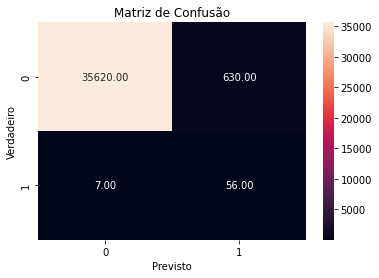

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9826    0.9911     36250
           1     0.0816    0.8889    0.1495        63

    accuracy                         0.9825     36313
   macro avg     0.5407    0.9358    0.5703     36313
weighted avg     0.9982    0.9825    0.9897     36313

Acurácia: 0.9825

AUC: 0.9358



In [ ]:
fig,ax = plt.subplots()

sns.heatmap(cfm, annot=True, ax=ax, fmt=".2f")
ax.set_title("Matriz de Confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")

plt.show();

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_val, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_val, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))

## **Desempenho do modelo de Regressão Logística com otimização de hiperparâmetros**

* Otimizaremos os hiperparâmetros e utilizaremos a técnica de *cross-validation*, a fim de confirmar se a sua otimização trará uma previsibilidade e uma generalização maior ao modelo.

**PENALIDADES:**

*   **Ridge L2:** Loss Function + lambda * slope^2
*   **Lasso L1:** Loss Function + lambda * |slope|
*   **Elastic-Net:** composição entre a penalidade L2 e L1

**HIPERPARÂMETROS:**

* **penalty:** estabelece qual parâmetro de penalidade atribuiremos a *Loss Function* para generalizar o nosso modelo (Ridge L2, Lasso L1 e elastic-net, que é uma combinação das duas penalidades). A força das regularizações será estabelecida pelo parâmetro alfa ou l1_ratio.

* **l1_ratio:** é o parâmetro alfa, mencionado acima, que regula as penalidades entre ridge ou lasso regression. l1_ratio = 0 é equivalente à penalidade L2, l1_ratio = 1 é equivalente à penalidade L1, 0 < l1_ratio < 1 é uma combinação das duas penalidades (elastic-net regression).

* **C:** é o inverso do lambda da equação do ridge e do lasso regression. Se C=1.0, então lambda = 0, o que ocasionará a eliminação dos parâmetros de penalidade e a equação vira um modelo de regressão logística normal como conhecemos. O parâmetro C atribui um peso inversamente proporcional ao seu número no parâmetro de penalidade.

* **solver:** uma das metodologias de se calcular os melhores parâmetros da equação (coeficientes e constante).

* **max_iter:** número máximo de iterações usadas para o solver convergir em um número para os parâmetros.

In [ ]:
from sklearn.model_selection import GridSearchCV

**ROUND 1**

* Foi escolhida a penalidade **elastic-net**, pois, de acordo com os valores de l1_ratio explicitados acima, se 0, teríamos então a escolha da penalidade L2 e, se 1, teríamos a escolha da penalidade L1. Logo poderíamos englobar a escolha da melhor penalidade na própria **elastic-net.**

* Foi escolhido o solver **Saga**, pois, segundo a documentação, é o solver que engloba o uso da **elastic-net.**

* Para melhor capacidade de processamento dos parâmetros, escolhemos apenas o **max_iter padrão = 100** e um **3-fold cross-validation.**

In [ ]:
model_gscv = LogisticRegression()

param_grid = [
              {
                  'penalty' : ['elasticnet'],
                  'l1_ratio': [0, 0.5, 1],
                  'C': [0.01, 1 ,10],
                  'solver' : ['saga'],
                  'max_iter' : [100]
              }
]

In [ ]:
clf = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=10)

In [ ]:
clf.fit(x_res, y_res)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=10,
             param_grid=[{'C': [0.01, 1, 10], 'l1_ratio': [0, 0.5, 1],
                          'max_iter': [100], 'penalty': ['elasticnet'],
                          'solver': ['saga']}],
             verbose=True)

## **Melhores Estimadores**

* Como C=1, o melhor parâmetro nos diz que a regressão logística sem a aplicação de nenhuma penalidade é a que trouxe o melhor resultado. 

* A única diferença entre o modelo de regressão logística padrão e o modelo com a otimização de hiperparâmetros, neste caso, é a escolha do **solver='saga'**, e não o parâmetro padrão **solver='lbfgs'**, que nos trouxe um AUC um pouco menor em relação ao modelo padrão.

In [ ]:
clf.best_estimator_

LogisticRegression(C=1, l1_ratio=1, penalty='elasticnet', solver='saga')

In [ ]:
model_gscv = LogisticRegression(C=1, l1_ratio=0, penalty='elasticnet', solver='saga')

In [ ]:
model_gscv.fit(X_res, y_res)

y_pred = model_gscv.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
cfm = confusion_matrix(y_val, y_pred)

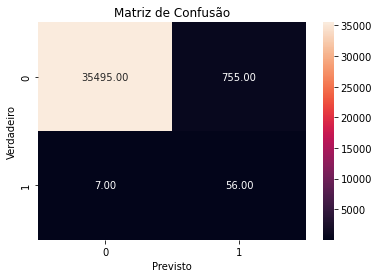

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9792    0.9894     36250
           1     0.0691    0.8889    0.1281        63

    accuracy                         0.9790     36313
   macro avg     0.5344    0.9340    0.5588     36313
weighted avg     0.9982    0.9790    0.9879     36313

Acurácia: 0.9790

AUC: 0.9340



In [ ]:
fig,ax = plt.subplots()

sns.heatmap(cfm, annot=True, ax=ax, fmt=".2f")
ax.set_title("Matriz de Confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")

plt.show();

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_val, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_val, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))

## **Avaliação do Modelo de Regressão Logística na Base Teste**

* Utilizaremos o modelo padrão, visto que nos retornou um **AUC** melhor em relação ao modelo com a otimização dos hiperparâmetros. 

In [ ]:
test_standard = test.copy()

std_scaler = StandardScaler()

test_standard["std_Amount"] = scaler.fit_transform(test_standard["Amount"].values.reshape(-1,1))
test_standard["std_Time"] = scaler.fit_transform(test_standard["Time"].values.reshape(-1,1))

test_standard.drop(columns=["Amount", "Time"], inplace=True)

test_standard.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_Amount,std_Time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,-1.118863,0.202647,1.145965,-1.802360,-0.247178,-0.060945,0.846606,0.379454,0.847262,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,-0.854776,-0.620458,-0.806471,-0.770837,-0.108158,0.258964,0.492095,-0.148516,-0.148099,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,1.551682,0.435125,-0.336022,0.278965,1.812232,0.080001,0.116347,0.291818,0.106228,-0.987790,0.810408,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,0.664531,-3.282511,0.409266,1.252202,-0.868774,0.214387,1.878003,-1.906559,0.263854,-0.126871,-0.139436,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


In [ ]:
test_standard.shape

(42721, 31)

In [ ]:
X_test = test_standard.drop("Class", axis=1)
y_test = test_standard["Class"]

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
cfm = confusion_matrix(y_test, y_test_pred)

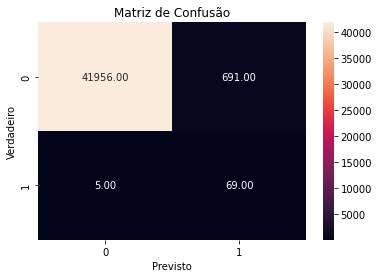

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9838    0.9918     42647
           1     0.0908    0.9324    0.1655        74

    accuracy                         0.9837     42721
   macro avg     0.5453    0.9581    0.5786     42721
weighted avg     0.9983    0.9837    0.9903     42721

Acurácia: 0.9837

AUC: 0.9581



In [ ]:
fig, ax = plt.subplots()

sns.heatmap(cfm, annot=True, ax=ax, fmt=".2f")
ax.set_title("Matriz de Confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")

plt.show();

print("Relatório de Classificação:\n", classification_report(y_test, y_test_pred, digits=4))

print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_test_pred)))

print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_test_pred)))

## **Conclusão**

* Foi aplicado um modelo de Regressão Logística para prever quais variáveis ocasionariam operações de fraudes ou não.

* Aplicamos um modelo padrão e um modelo com otimização de hiperparâmetros, a fim de descobrir qual seria o modelo mais generalista e que retornaria métricas de avaliação melhores.

* Foi escolhido o modelo padrão que nos retornou para classificação de fraudes = 1:

  1.   Acurácia: 0.9614
  2.   AUC: 0.9469
  3.   Precision: 0.0402
  4.   Recall: 0.9324
  5.   f1-score: 0.0771

* Neste caso, a precision e f1-score não são boas métricas de avaliação, visto que, devido ao desbalanceamento dos dados, a quantidade de erros falsos positivos serão maiores, dado que existem uma quantidade muito maior de classificações 0 em relação a 1.

* Pelas avaliações que desconsideram o falso positivo em seus cálculos, o modelo se mostrou bastante robusto e generalista.


